## LightGBM
From the previous runs, lightGBM came out as the top model (with default parameters). I thought that it might perform better with hyperparameter tuning.

<a href="https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html">The documentation</a> for LGBM suggested to try (1) large max_bin (may be slower) (2) small learning_rate with large num_iterations (3) large num_leaves (may cause over-fitting) (4) Try dart to achieve better accuracy. 

Here are some of the links I found useful for understanding LightGBM parameters:
- https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc
- https://www.codementor.io/@mikekraus/using-bayesian-optimisation-to-reduce-the-time-spent-on-hyperparameter-tuning-tgc3ikmp2
-https://towardsdatascience.com/automated-machine-learning-hyperparameter-tuning-in-python-dfda59b72f8a

In [3]:
#Import the relevant dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
import math
import re
import lightgbm as lgb
import xgboost as xgb
import shap  # package used to calculate Shap values
import warnings

from tqdm import tqdm
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.stats import randint, uniform

from hyperopt import hp, tpe, Trials, STATUS_OK
from hyperopt.fmin import fmin
from hyperopt.pyll.stochastic import sample

/Users/ftt.huien.pang/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [5]:
df=pd.read_csv(r'/Users/ftt.huien.pang/Documents/Grab_AISEA/safety/features/dataframeD.csv')

In [6]:
feat_cols=['bearing_diff_range', 'Speed_abs_max', 'pitch_gyro_min',
           'acc_tot_diff_min', 'gyro_tot_skew', 'acc_tot_diff_q25', 'gyro_tot_iqr',
           'tilt_angle_skewness', 'horsepower_sign_change', 'Speed_SRAV',
           'Accuracy_range', 'acceleration_x_abs_avg', 'Bearing_mean_abs_chg',
           'roll_gyro_abs_max', 'tilt_angle_abs_avg', 'gyro_tot_abs_min',
           'Speed_range', 'gyro_tot_diff_max', 'second_max',
           'pitch_gyro_mean_abs_chg', 'Distance_sum', 'acc_tot_abs_min',
           'bearing_diff_mad', 'gyro_tot_ssc', 'Bearing_range', 'gyro_y_skewness',
           'horsepower_median', 'tilt_angle_range', 'Bearing_median',
           'acceleration_z_std', 'Speed_percentile_90', 'acceleration_y_SRAV',
           'speed_diff_q75', 'gyro_y_percentile_90', 'horsepower_skewness',
           'Bearing_q25', 'acceleration_z_abs_max', 'gyro_z_range', 'Bearing_iqr',
           'acceleration_x_skewness', 'acc_tot_mean_abs', 'speed_diff_min',
           'acc_tot_skewness']

In [13]:
X =  df.drop(columns=['bookingID','label','Unnamed: 0']).reset_index(drop=True)[feat_cols]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [14]:
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
import pandas as pd
import time

def search(pipeline, parameters, X_train, y_train, X_test, y_test, optimizer='grid_search', n_iter=None):
    
    start = time.time() 
    
    if optimizer == 'grid_search':
        grid_obj = GridSearchCV(estimator=pipeline,
                                param_grid=parameters,
                                cv=5,
                                refit=True,
                                return_train_score=False,
                                scoring = 'accuracy',
                               )
        grid_obj.fit(X_train, y_train,)
    
    elif optimizer == 'random_search':
        grid_obj = RandomizedSearchCV(estimator=pipeline,
                            param_distributions=parameters,
                            cv=5,
                            n_iter=n_iter,
                            refit=True,
                            return_train_score=False,
                            scoring = 'accuracy',
                            random_state=1)
        grid_obj.fit(X_train, y_train,)
    
    else:
        print('enter search method')
        return

    estimator = grid_obj.best_estimator_
    cvs = cross_val_score(estimator, X_train, y_train, cv=5)
    results = pd.DataFrame(grid_obj.cv_results_)
    
    print("##### Results")
    print("Score best parameters: ", grid_obj.best_score_)
    print("Best parameters: ", grid_obj.best_params_)
    print("Cross-validation Score: ", cvs.mean())
    print("Test Score: ", estimator.score(X_test, y_test))
    print("Time elapsed: ", time.time() - start)
    print("Parameter combinations evaluated: ",results.shape[0])
    
    return results, estimator

In [15]:
import lightgbm as lgb
import numpy as np
from sklearn import pipeline
from hyperopt import hp

pipe = pipeline.Pipeline([
    ('clf', lgb.LGBMClassifier())
    ])

param_gridsearch = {
    'clf__learning_rate' : [0.01, 0.1, 1],
    'clf__max_depth' : [5, 10, 15],
    'clf__n_estimators' : [5, 20, 35], 
    'clf__num_leaves' : [5, 25, 50],
    'clf__boosting_type': ['gbdt', 'dart'],
    'clf__colsample_bytree' : [0.6, 0.75, 1],
    'clf__reg_lambda': [0.01, 0.1, 1],
}

param_random = {
    'clf__learning_rate': list(np.logspace(np.log(0.01), np.log(1), num = 500, base=3)),
    'clf__max_depth': list(range(5, 15)),
    'clf__n_estimators': list(range(5, 35)),
    'clf__num_leaves': list(range(5, 50)),
    'clf__boosting_type': ['gbdt', 'dart'],
    'clf__colsample_bytree': list(np.linspace(0.6, 1, 500)),
    'clf__reg_lambda': list(np.linspace(0, 1, 500)),
}

In [21]:
from hyperopt.pyll import scope
param_hyperopt= {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 15, 1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 5, 35, 1)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 5, 50, 1)),
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart']),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
}

In [18]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from time import time

def hyperopt(param_space, X_train, y_train, X_test, y_test, num_eval):
    
    start = time.time()
    
    def objective_function(params):
        clf = lgb.LGBMClassifier(**params)
        score = cross_val_score(clf, X_train, y_train, cv=5).mean()
        return {'loss': -score, 'status': STATUS_OK}

    trials = Trials()
    best_param = fmin(objective_function, 
                      param_space, 
                      algo=tpe.suggest, 
                      max_evals=num_eval, 
                      trials=trials,
                      rstate= np.random.RandomState(1))
    loss = [x['result']['loss'] for x in trials.trials]
    
    best_param_values = [x for x in best_param.values()]
    
    if best_param_values[0] == 0:
        boosting_type = 'gbdt'
    else:
        boosting_type= 'dart'
    
    clf_best = lgb.LGBMClassifier(learning_rate=best_param_values[2],
                                  num_leaves=int(best_param_values[5]),
                                  max_depth=int(best_param_values[3]),
                                  n_estimators=int(best_param_values[4]),
                                  boosting_type=boosting_type,
                                  colsample_bytree=best_param_values[1],
                                  reg_lambda=best_param_values[6],
                                 )
                                  
    clf_best.fit(X_train, y_train)
    
    print("")
    print("##### Results")
    print("Score best parameters: ", min(loss)*-1)
    print("Best parameters: ", best_param)
    print("Test Score: ", clf_best.score(X_test, y_test))
    print("Time elapsed: ", time.time() - start)
    print("Parameter combinations evaluated: ", num_eval)
    
    return trials

In [23]:
import time
num_eval =100

results_grid, estimator_grid = search(pipe, param_gridsearch, X_train, y_train, X_test, y_test, 'grid_search')

##### Results
Score best parameters:  0.7841726618705036
Best parameters:  {'clf__boosting_type': 'gbdt', 'clf__colsample_bytree': 0.75, 'clf__learning_rate': 0.1, 'clf__max_depth': 10, 'clf__n_estimators': 20, 'clf__num_leaves': 50, 'clf__reg_lambda': 0.1}
Cross-validation Score:  0.7841727820201312
Test Score:  0.7705779334500875
Time elapsed:  1696.9888498783112
Parameter combinations evaluated:  1458


In [24]:
results_random, estimator_random = search(pipe, param_random, X_train, y_train, X_test, y_test, 'random_search', num_eval)

##### Results
Score best parameters:  0.7839224272755708
Best parameters:  {'clf__reg_lambda': 0.8096192384769538, 'clf__num_leaves': 32, 'clf__n_estimators': 28, 'clf__max_depth': 8, 'clf__learning_rate': 0.13030035865873227, 'clf__colsample_bytree': 0.7819639278557113, 'clf__boosting_type': 'gbdt'}
Cross-validation Score:  0.7839225278144288
Test Score:  0.7708281210908181
Time elapsed:  76.87539672851562
Parameter combinations evaluated:  100


In [25]:
results_hyperopt = hyperopt(param_hyperopt, X_train, y_train, X_test, y_test, num_eval)

100%|██████████| 100/100 [01:34<00:00,  1.06trial/s, best loss: -0.7844232515036074]

##### Results
Score best parameters:  0.7844232515036074
Best parameters:  {'boosting_type': 1, 'colsample_by_tree': 0.641362438998802, 'learning_rate': 0.19395452817183978, 'max_depth': 12.0, 'n_estimators': 30.0, 'num_leaves': 27.0, 'reg_lambda': 0.6643074740574251}
Test Score:  0.7713284963722792
Time elapsed:  94.24662923812866
Parameter combinations evaluated:  100


This shows the Hyperopt can get similar performance despite running in a much lesser than compared to GridSearchCV. Referenced from <a href='https://towardsdatascience.com/intuitive-hyperparameter-optimization-grid-search-random-search-and-bayesian-search-2102dbfaf5b'> this link </a>.

## Parameter tuning with Hyperopt

In [197]:
train_df, test_df=train_test_split(df,test_size=0.2,random_state=99)
X =  train_df.drop(columns=['bookingID','label','Unnamed: 0']).reset_index(drop=True)[feat_cols]
y = train_df['label']
features=X.columns
#feat=features_df['features']
#cut_features= pd.Index(feat)

In [198]:
random_state = 42
np.random.seed(random_state)

folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)

### LGB parameters- binary log_loss
I used 'binary log_loss' as the metric to reduce loss.

In [199]:
from hyperopt import hp, tpe, Trials, STATUS_OK
from hyperopt.fmin import fmin
from hyperopt.pyll.stochastic import sample

LGBM_MAX_LEAVES = 2**10 # maximum number of leaves per tree for lgb
LGBM_MAX_DEPTH = 25 # maximum tree depth for lgb
EVAL_METRIC_LGBM_CLASS = 'binary_logloss' #lgb classification metric
N_FOLDS = 5

def quick_hyperopt(data, labels, package, num_evals, diagnostic=False, Class=True):
    
    #==========
    # LightGBM
    #==========
    
    if package=='lgbm':
        
        print('Running {} rounds of LightGBM parameter optimisation:'.format(num_evals))
        # clear space
        gc.collect()
        
        integer_params = ['max_depth',
                         'num_leaves',
                          'max_bin',
                         'min_data_in_leaf',
                         'min_data_in_bin']
        
        def objective(space_params):
            
            # cast integer params from float to int
            for param in integer_params:
                space_params[param] = int(space_params[param])
            
            # extract nested conditional parameters
            if space_params['boosting']['boosting'] == 'goss':
                top_rate = space_params['boosting'].get('top_rate')
                other_rate = space_params['boosting'].get('other_rate')
                #0 <= top_rate + other_rate <= 1
                top_rate = max(top_rate, 0)
                top_rate = min(top_rate, 0.5)
                other_rate = max(other_rate, 0)
                other_rate = min(other_rate, 0.5)
                space_params['top_rate'] = top_rate
                space_params['other_rate'] = other_rate
            
            subsample = space_params['boosting'].get('subsample', 1.0)
            space_params['boosting'] = space_params['boosting']['boosting']
            space_params['subsample'] = subsample
            
            if Class:
                cv_results = lgb.cv(space_params, train, nfold = N_FOLDS, stratified=True,
                                    early_stopping_rounds=100, metrics=EVAL_METRIC_LGBM_CLASS, seed=42)
                best_loss = cv_results['binary_logloss-mean'][-1]
                
            else:
                cv_results = lgb.cv(space_params, train, nfold = N_FOLDS, stratified=False,
                                    early_stopping_rounds=100, metrics=EVAL_METRIC_LGBM_REG, seed=42)
                best_loss = cv_results['l1-mean'][-1] #'l2-mean' for rmse
            
            return{'loss':best_loss, 'status': STATUS_OK }
        
        train = lgb.Dataset(data, labels)
                
        # integer and string parameters, used with hp.choice()
        boosting_list = [{'boosting': 'gbdt',
                          'subsample': hp.uniform('subsample', 0.5, 1)},
                         {'boosting': 'goss',
                          'subsample': 1.0,
                         'top_rate': hp.uniform('top_rate', 0, 0.5),
                         'other_rate': hp.uniform('other_rate', 0, 0.5)}] 
        
        if Class:
            metric_list = ['binary_logloss'] # modify as required for other classification metrics
            objective_list = ['binary']
        
        else:
            metric_list = ['MAE', 'RMSE'] 
            objective_list = ['huber', 'gamma', 'fair', 'tweedie']
        
        
        space ={'boosting' : hp.choice('boosting', boosting_list),
                'num_leaves' : hp.quniform('num_leaves', 2, LGBM_MAX_LEAVES, 1),
                'max_depth': hp.quniform('max_depth', 2, LGBM_MAX_DEPTH, 1),
                'max_bin': hp.quniform('max_bin', 32, 255, 1),
                'min_data_in_leaf': hp.quniform('min_data_in_leaf', 1, 256, 1),
                'min_data_in_bin': hp.quniform('min_data_in_bin', 1, 256, 1),
                'min_gain_to_split' : hp.quniform('min_gain_to_split', 0.1, 5, 0.01),
                'lambda_l1' : hp.uniform('lambda_l1', 0, 5),
                'lambda_l2' : hp.uniform('lambda_l2', 0, 5),
                'learning_rate' : hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
                'metric' : hp.choice('metric', metric_list),
                'objective' : hp.choice('objective', objective_list),
                'feature_fraction' : hp.quniform('feature_fraction', 0.5, 1, 0.01),
                'bagging_fraction' : hp.quniform('bagging_fraction', 0.5, 1, 0.01)
            }
        

        trials = Trials()
        best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=num_evals, 
                    trials=trials)
        
                
        best['boosting'] = boosting_list[best['boosting']]['boosting']
        best['metric'] = metric_list[best['metric']]
        best['objective'] = objective_list[best['objective']]
                
        for param in integer_params:
            best[param] = int(best[param])
        
        print('{' + '\n'.join('{}: {}'.format(k, v) for k, v in best.items()) + '}')
        if diagnostic:
            return(best, trials)
        else:
            return(best)
          
lgbm_params = quick_hyperopt(train_df[features], train_df['label'], 'lgbm', 100, Class=True)

Running 100 rounds of LightGBM parameter optimisation:
100%|██████████| 100/100 [02:43<00:00,  1.64s/trial, best loss: 0.476609428539681] 
{bagging_fraction: 0.98
boosting: gbdt
feature_fraction: 0.51
lambda_l1: 0.5132628117241198
lambda_l2: 2.29490915620267
learning_rate: 0.07544872924041326
max_bin: 183
max_depth: 5
metric: binary_logloss
min_data_in_bin: 177
min_data_in_leaf: 31
min_gain_to_split: 0.24
num_leaves: 857
objective: binary
subsample: 0.7864891103486246}


In [200]:
lgb_params = { # 100 iterations on 40+ features
    'bagging_fraction': 0.98,
    'boosting': 'gbdt',
    'feature_fraction': 0.51,
    'lambda_l1': 0.5132628117241198,
    'lambda_l2': 2.29490915620267,
    'learning_rate': 0.07544872924041326,
    'max_bin': 183,
    'max_depth': 5,
    'metric': 'binary_logloss',
    'min_data_in_bin': 177,
    'min_data_in_leaf': 31,
    'min_gain_to_split': 0.24,
    'num_leaves': 857,
    'objective': 'binary',
    'subsample': 0.7864891103486246
}

In [201]:
# ==================
# out of fold validation
# ==================
val_aucs = []
feature_importance_df = pd.DataFrame()

oof = train_df[['bookingID', 'label']]
oof['predict'] = 0
oof = oof.reset_index()

# # UNCOMMENT
# oof_test = np.zeros((len(test_df), ))
# oof_test_skf = np.empty((folds, len(test_df),))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [202]:
%%time
for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['label'])):
    X_train, y_train = train_df.iloc[trn_idx][features], train_df.iloc[trn_idx]['label']
    X_valid, y_valid = train_df.iloc[val_idx][features], train_df.iloc[val_idx]['label']

    trn_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    
    evals_result = {}
    
    lgb_clf = lgb.train(lgb_params,
                        trn_data,
                        1000,
                        valid_sets=[trn_data, val_data],
                        early_stopping_rounds=200,
                        verbose_eval=200,
                        evals_result=evals_result)

    p_valid = lgb_clf.predict(X_valid, 
                              num_iteration=lgb_clf.best_iteration)
    
    # # UNCOMMENT
    # oof_test_skf[fold, :] = lgb_clf.predict(test_df[features],
    #                                         num_iteration=lgb_clf.best_iteration)
    

    oof['predict'][val_idx] = p_valid
    oof['predict']=np.where(oof['predict'] > 0.5, 1, 0)
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)
    
# # UNCOMMENT    
# oof_test[:] = oof_test_skf.mean(axis=0)

Training until validation scores don't improve for 200 rounds
[200]	training's binary_logloss: 0.365518	valid_1's binary_logloss: 0.480466
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.419444	valid_1's binary_logloss: 0.478439
Training until validation scores don't improve for 200 rounds
[200]	training's binary_logloss: 0.361013	valid_1's binary_logloss: 0.467101
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.381199	valid_1's binary_logloss: 0.466143
Training until validation scores don't improve for 200 rounds
[200]	training's binary_logloss: 0.361955	valid_1's binary_logloss: 0.474883
Early stopping, best iteration is:
[129]	training's binary_logloss: 0.398933	valid_1's binary_logloss: 0.473412
Training until validation scores don't improve for 200 rounds
[200]	training's binary_logloss: 0.360408	valid_1's binary_logloss: 0.482202
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.417209	valid_1's binary_logloss: 0.4782


In [203]:
y_test = test_df['label']
test=y_test.T
dfA = pd.Series(test)
grouped = dfA.groupby(dfA).count()
print("Number of occurence of each value in result test set :")
print(grouped)

yhat=lgb_clf.predict(test_df[feat_cols])
#yhat = np.where(yhat > 0.5, 1, 0)
test2 = yhat.T
dfA = pd.Series(test2)
grouped = dfA.groupby(dfA).count()
print("Number of occurence of each value in result test set after going through the ML:")
print(grouped)

#print ("Classification report : \n" + classification_report(y_test, yhat))
scores=roc_auc_score(y_test, yhat)
print("ROC_AUC_score :")
print(scores)

Number of occurence of each value in result test set :
label
0    2986
1    1011
Name: label, dtype: int64
Number of occurence of each value in result test set after going through the ML:
0.004941    1
0.006520    1
0.006994    1
0.007047    1
0.007125    1
           ..
0.976831    1
0.977041    1
0.978071    1
0.979415    1
0.982869    1
Length: 3997, dtype: int64
ROC_AUC_score :
0.7310929408124826


### ROC_AUC score after classifying
Classified based on thresholds to the imbalanced labels in the dataset. A threshold of 0.24 gives the best ROC_AUC score (0.6684981612178958)

In [204]:
y_test = test_df['label']
test=y_test.T
dfA = pd.Series(test)
grouped = dfA.groupby(dfA).count()
print("Number of occurence of each value in result test set :")
print(grouped)

yhat=lgb_clf.predict(test_df[feat_cols])
yhat = np.where(yhat > 0.24, 1, 0)
test2 = yhat.T
dfA = pd.Series(test2)
grouped = dfA.groupby(dfA).count()
print("Number of occurence of each value in result test set after going through the ML:")
print(grouped)

print ("Classification report : \n" + classification_report(y_test, yhat))
scores=roc_auc_score(y_test, yhat)
print("ROC_AUC_score :")
print(scores)

Number of occurence of each value in result test set :
label
0    2986
1    1011
Name: label, dtype: int64
Number of occurence of each value in result test set after going through the ML:
0    2390
1    1607
dtype: int64
Classification report : 
              precision    recall  f1-score   support

           0       0.85      0.68      0.76      2986
           1       0.41      0.65      0.50      1011

    accuracy                           0.68      3997
   macro avg       0.63      0.67      0.63      3997
weighted avg       0.74      0.68      0.69      3997

ROC_AUC_score :
0.6684981612178958


In [205]:
def thresholding2(x):
    y_test = test_df['label']
    yhat=lgb_clf.predict(test_df[feat_cols])
    yhat = np.where(yhat >x, 1, 0)
    scores=roc_auc_score(y_test, yhat)
    return scores

for x in np.linspace(0, 1, 101):
    threshold=thresholding(x)
    print(x,threshold)

0.0 0.5
0.01 0.5
0.02 0.5050234427327529
0.03 0.5157401205626255
0.04 0.5258103593227346
0.05 0.5341827638773227
0.06 0.5422436255443306
0.07 0.5519867525537904
0.08 0.5602462000380277
0.09 0.5726684965049558
0.1 0.5813017623290488
0.11 0.5891055721292175
0.12 0.596886028634783
0.13 0.6027193834995226
0.14 0.6100286334579506
0.15 0.6190512864849681
0.16 0.6277468277613366
0.17 0.633954000965932
0.18 0.6446511349038673
0.19 0.657174628980743
0.2 0.6562905163098747
0.21 0.6585334263490089
0.22 0.6619718263203886
0.23 0.66121623958294
0.24 0.6649428291472966
0.25 0.6634940967508778
0.26 0.6654839299520413
0.27 0.6616753554172685
0.28 0.6580497978366567
0.29 0.6560597990092903
0.3 0.6542061105468777
0.31 0.6480532627368206
0.32 0.6434074477465892
0.33 0.6404205448042067
0.34 0.6413434140065443
0.35000000000000003 0.637967123861237
0.36 0.6357396170589689
0.37 0.6338470064388843
0.38 0.6268335648787648
0.39 0.6235935850984117
0.4 0.621319371706937
0.41000000000000003 0.6149368003535125
0.42

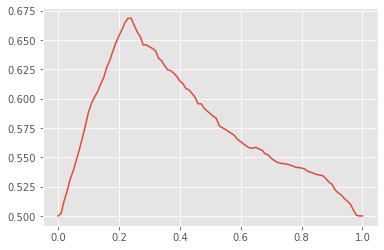

In [206]:
x=np.linspace(0, 1, 101)
y=np.array([thresholding2(x) for x in np.linspace(0, 1, 101)])
#plt.plot(x, y)
plt.plot(x,y)
plt.show()

### LGB parameters- auc
I used 'auc' as the metric to maximise auc.

In [207]:
from hyperopt import hp, tpe, Trials, STATUS_OK
from hyperopt.fmin import fmin
from hyperopt.pyll.stochastic import sample

LGBM_MAX_LEAVES = 2**10 # maximum number of leaves per tree for lgb
LGBM_MAX_DEPTH = 25 # maximum tree depth for lgb
EVAL_METRIC_LGBM_CLASS = 'auc' #lgb classification metric
N_FOLDS = 5

def quick_hyperopt(data, labels, package, num_evals, diagnostic=False, Class=True):
    
    #==========
    # LightGBM
    #==========
    
    if package=='lgbm':
        
        print('Running {} rounds of LightGBM parameter optimisation:'.format(num_evals))
        # clear space
        gc.collect()
        
        integer_params = ['max_depth',
                         'num_leaves',
                          'max_bin',
                         'min_data_in_leaf',
                         'min_data_in_bin']
        
        def objective(space_params):
            
            # cast integer params from float to int
            for param in integer_params:
                space_params[param] = int(space_params[param])
            
            # extract nested conditional parameters
            if space_params['boosting']['boosting'] == 'goss':
                top_rate = space_params['boosting'].get('top_rate')
                other_rate = space_params['boosting'].get('other_rate')
                #0 <= top_rate + other_rate <= 1
                top_rate = max(top_rate, 0)
                top_rate = min(top_rate, 0.5)
                other_rate = max(other_rate, 0)
                other_rate = min(other_rate, 0.5)
                space_params['top_rate'] = top_rate
                space_params['other_rate'] = other_rate
            
            subsample = space_params['boosting'].get('subsample', 1.0)
            space_params['boosting'] = space_params['boosting']['boosting']
            space_params['subsample'] = subsample
            
            if Class:
                cv_results = lgb.cv(space_params, train, nfold = N_FOLDS, stratified=True,
                                    early_stopping_rounds=100, metrics=EVAL_METRIC_LGBM_CLASS, seed=42)
                best_loss = 1 - cv_results['auc-mean'][-1]
                
            else:
                cv_results = lgb.cv(space_params, train, nfold = N_FOLDS, stratified=False,
                                    early_stopping_rounds=100, metrics=EVAL_METRIC_LGBM_REG, seed=42)
                best_loss = cv_results['l1-mean'][-1] #'l2-mean' for rmse
            
            return{'loss':best_loss, 'status': STATUS_OK }
        
        train = lgb.Dataset(data, labels)
                
        # integer and string parameters, used with hp.choice()
        boosting_list = [{'boosting': 'gbdt',
                          'subsample': hp.uniform('subsample', 0.5, 1)},
                         {'boosting': 'goss',
                          'subsample': 1.0,
                         'top_rate': hp.uniform('top_rate', 0, 0.5),
                         'other_rate': hp.uniform('other_rate', 0, 0.5)}] 
        
        if Class:
            metric_list = ['auc'] # modify as required for other classification metrics
            objective_list = ['binary']
        
        else:
            metric_list = ['MAE', 'RMSE'] 
            objective_list = ['huber', 'gamma', 'fair', 'tweedie']
        
        
        space ={'boosting' : hp.choice('boosting', boosting_list),
                'num_leaves' : hp.quniform('num_leaves', 2, LGBM_MAX_LEAVES, 1),
                'max_depth': hp.quniform('max_depth', 2, LGBM_MAX_DEPTH, 1),
                'max_bin': hp.quniform('max_bin', 32, 255, 1),
                'min_data_in_leaf': hp.quniform('min_data_in_leaf', 1, 256, 1),
                'min_data_in_bin': hp.quniform('min_data_in_bin', 1, 256, 1),
                'min_gain_to_split' : hp.quniform('min_gain_to_split', 0.1, 5, 0.01),
                'lambda_l1' : hp.uniform('lambda_l1', 0, 5),
                'lambda_l2' : hp.uniform('lambda_l2', 0, 5),
                'learning_rate' : hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
                'metric' : hp.choice('metric', metric_list),
                'objective' : hp.choice('objective', objective_list),
                'feature_fraction' : hp.quniform('feature_fraction', 0.5, 1, 0.01),
                'bagging_fraction' : hp.quniform('bagging_fraction', 0.5, 1, 0.01)
            }
        

        trials = Trials()
        best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=num_evals, 
                    trials=trials)
        
                
        best['boosting'] = boosting_list[best['boosting']]['boosting']
        best['metric'] = metric_list[best['metric']]
        best['objective'] = objective_list[best['objective']]
                
        for param in integer_params:
            best[param] = int(best[param])
        
        print('{' + '\n'.join('{}: {}'.format(k, v) for k, v in best.items()) + '}')
        if diagnostic:
            return(best, trials)
        else:
            return(best)
          
lgbm_params = quick_hyperopt(train_df[features], train_df['label'], 'lgbm', 100, Class=True)

Running 100 rounds of LightGBM parameter optimisation:
100%|██████████| 100/100 [02:17<00:00,  1.37s/trial, best loss: 0.2595232436820727]
{bagging_fraction: 0.77
boosting: goss
feature_fraction: 0.64
lambda_l1: 1.6775082090596447
lambda_l2: 2.950949657786254
learning_rate: 0.08356746377254974
max_bin: 197
max_depth: 5
metric: auc
min_data_in_bin: 37
min_data_in_leaf: 60
min_gain_to_split: 1.35
num_leaves: 919
objective: binary
other_rate: 0.3366667634600221
top_rate: 0.33038903968695366}


In [208]:
lgb_params2 = { # 100 iterations on 40+ features
    'bagging_fraction': 0.77,
    'boosting': 'goss',
    'feature_fraction': 0.64,
    'lambda_l1': 1.6775082090596447,
    'lambda_l2': 2.950949657786254,
    'learning_rate': 0.08356746377254974,
    'max_bin': 197,
    'max_depth': 5,
    'metric': 'auc',
    'min_data_in_bin': 37,
    'min_data_in_leaf': 60,
    'min_gain_to_split': 1.35,
    'num_leaves': 919,
    'objective': 'binary',
    'other_rate': 0.3366667634600221,
    'top_rate':0.33038903968695366
}

In [209]:
# ==================
# out of fold validation
# ==================
val_aucs = []
feature_importance_df = pd.DataFrame()

oof = train_df[['bookingID', 'label']]
oof['predict'] = 0
oof = oof.reset_index()

# # UNCOMMENT
# oof_test = np.zeros((len(test_df), ))
# oof_test_skf = np.empty((folds, len(test_df),))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [210]:
%%time
for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['label'])):
    X_train, y_train = train_df.iloc[trn_idx][features], train_df.iloc[trn_idx]['label']
    X_valid, y_valid = train_df.iloc[val_idx][features], train_df.iloc[val_idx]['label']

    trn_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    
    evals_result = {}
    
    lgb_clf2 = lgb.train(lgb_params2,
                        trn_data,
                        1000,
                        valid_sets=[trn_data, val_data],
                        early_stopping_rounds=200,
                        verbose_eval=200,
                        evals_result=evals_result)

    p_valid = lgb_clf2.predict(X_valid, 
                              num_iteration=lgb_clf2.best_iteration)
    
    # # UNCOMMENT
    # oof_test_skf[fold, :] = lgb_clf.predict(test_df[features],
    #                                         num_iteration=lgb_clf.best_iteration)
    

    oof['predict'][val_idx] = p_valid
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)
    
# # UNCOMMENT    
# oof_test[:] = oof_test_skf.mean(axis=0)

Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.900413	valid_1's auc: 0.737678
Early stopping, best iteration is:
[103]	training's auc: 0.845172	valid_1's auc: 0.740775
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.905166	valid_1's auc: 0.748097
Early stopping, best iteration is:
[63]	training's auc: 0.816259	valid_1's auc: 0.753526



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.900949	valid_1's auc: 0.747887
Early stopping, best iteration is:
[179]	training's auc: 0.892764	valid_1's auc: 0.749557



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.899293	valid_1's auc: 0.730744
Early stopping, best iteration is:
[101]	training's auc: 0.847261	valid_1's auc: 0.736616



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.901795	valid_1's auc: 0.719359
Early stopping, best iteration is:
[196]	training's auc: 0.900242	valid_1's auc: 0.719795
CPU times: user 31.9 s, sys: 3.04 s, total: 35 s
Wall time: 5.42 s



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


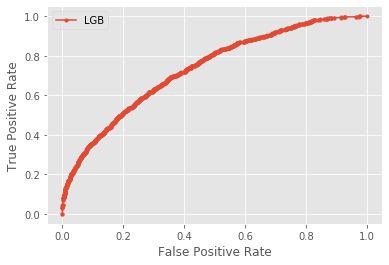

In [124]:
import matplotlib.pyplot as pyplot

X_test =  test_df.drop(columns=['bookingID','label','Unnamed: 0']).reset_index(drop=True)[feat_cols]
y_test = test_df['label']

lgb_probs=lgb_clf2.predict(X_test)
# calculate scores
lr_auc = roc_auc_score(y_test, lgb_probs)
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lgb_probs)
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='LGB')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [215]:

y_test = test_df['label']
test=y_test.T
dfA = pd.Series(test)
grouped = dfA.groupby(dfA).count()
print("Number of occurence of each value in result test set :")
print(grouped)

yhat=lgb_clf2.predict(test_df[feat_cols])
yhat = np.where(yhat > 0.22, 1, 0)
test2 = yhat.T
dfA = pd.Series(test2)
grouped = dfA.groupby(dfA).count()
print("Number of occurence of each value in result test set after going through the ML:")
print(grouped)

print ("Classification report : \n" + classification_report(y_test, yhat))
scores=roc_auc_score(y_test, yhat)
print("ROC_AUC_score :")
print(scores)

Number of occurence of each value in result test set :
label
0    2986
1    1011
Name: label, dtype: int64
Number of occurence of each value in result test set after going through the ML:
0    2190
1    1807
dtype: int64
Classification report : 
              precision    recall  f1-score   support

           0       0.85      0.63      0.72      2986
           1       0.38      0.68      0.49      1011

    accuracy                           0.64      3997
   macro avg       0.62      0.66      0.61      3997
weighted avg       0.74      0.64      0.66      3997

ROC_AUC_score :
0.6555307889173545


In [214]:
def thresholding(x):
    y_test = test_df['label']
    yhat=lgb_clf2.predict(test_df[feat_cols])
    yhat = np.where(yhat >x, 1, 0)
    scores=roc_auc_score(y_test, yhat)
    return scores

for x in np.linspace(0, 1, 101):
    threshold=thresholding(x)
    print(x,threshold)

0.0 0.5
0.01 0.5077026121902211
0.02 0.5186023069742544
0.03 0.5316788269424807
0.04 0.5403939121107867
0.05 0.5487974543915125
0.06 0.5603902948345162
0.07 0.5706513349803203
0.08 0.5806241855331474
0.09 0.593396947045328
0.1 0.6021743076659094
0.11 0.6086696704634817
0.12 0.611991303961845
0.13 0.6151688426637199
0.14 0.6236735825543933
0.15 0.6358388271544821
0.16 0.637579392920341
0.17 0.6399430444613605
0.18 0.6441408405728547
0.19 0.6460722077244088
0.2 0.6512357702247812
0.21 0.6538291453091678
0.22 0.6555307889173545
0.23 0.6543858149769813
0.24 0.6537120475837456
0.25 0.6525515047803034
0.26 0.6519244439762744
0.27 0.653914277177438
0.28 0.6529133980335532
0.29 0.6522318462087832
0.3 0.6497239342450724
0.31 0.6520097414707475
0.32 0.6516241636704886
0.33 0.649747121913473
0.34 0.6481816230440374
0.35000000000000003 0.6481075881313588
0.36 0.6427374897560193
0.37 0.6360355910834803
0.38 0.633617282895517
0.39 0.63024099275021
0.4 0.6222150782120055
0.41000000000000003 0.6199564

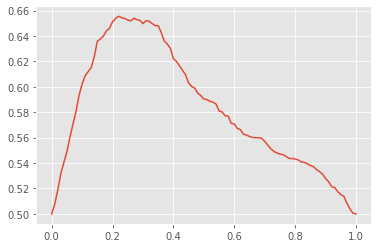

In [213]:
x=np.linspace(0, 1, 101)
y=np.array([thresholding(x) for x in np.linspace(0, 1, 101)])
#plt.plot(x, y)
plt.plot(x,y)
plt.show()

We can see that the ROC_AUC score is the highest (0.6555307889173545) when classifying with a threshold of 0.22.  

### Summary
For parameter tuning with Hyperopt, there wasn't a big difference in ROC_AUC score regardless of using 'binary_logloss' or 'auc' as metric. For both, setting a threshold of 0.24 to classify the predicated probabilities gave the best ROC_AUC score of approximately 0.66.

### What didn't work
- I think I spent wayyyyy too much time finding the "best" model. It was more efficient when I finally decided on one and worked to improve it instead.
- If I had more time, I would like to approach this problem using a rolling window (and aggregating by mean, max, min etc). It would make more sense to classify the trip based on 'events'/parts of the signal rather than aggregating the whole 'signal' instead.

I've made alot of mistakes along the way and learnt alot from this challenge. Huge shoutout to Afif for patiently answering my questions and Ira for guiding us both!!